In [1]:
import configparser
from phidown.search import CopernicusDataSearcher
import pandas as pd
import random
# ------ config reading ------
def read_config(config_path: str) -> configparser.ConfigParser:
    """
    Reads a configuration file and returns a ConfigParser object.

    Args:
        config_path (str): Path to the configuration file.

    Returns:
        configparser.ConfigParser: Parsed configuration object.

    Raises:
        AssertionError: If the config file cannot be read.
    """
    config = configparser.ConfigParser()
    read_files = config.read(config_path)
    assert read_files, f'Failed to read config file at {config_path}'
    return config

config = read_config('/Data_large/marine/PythonProjects/SAR/sarpyx/scripts/down/config.ini')
zones = list(config["STRIPWKTS"].keys())
print(f'Available zones: {zones}')

Available zones: ['dakhla', 'guyana', 'sanpaolo', 'panama', 'houston', 'maine', 'portland', 'california', 'honololu', 'almeria', 'melilla', 'algeria', 'aden', 'bangladesh', 'taiwan', 'biscay', 'brest', 'norwich', 'englishchannel', 'northsea', 'iceland', 'amsterdam', 'durban', 'seychelles', 'portblair', 'vanuatu', 'thunderbay', 'genoa', 'miami', 'seattle', 'burlington', 'southpole', 'havana', 'britishcolumbia', 'clayton', 'westaustralia', 'norway', 'boston', 'northengland', 'portalfred', 'paraiso', 'cignectobay', 'lakeconstance', 'rotterdam']


In [2]:
def sample_products_by_month(df: pd.DataFrame, date_column: str = 'PublicationDate', max_products: int = 12) -> pd.DataFrame:
    """
    Samples up to max_products from the dataframe, each from a different month, with random years.

    Args:
        df (pd.DataFrame): DataFrame containing product metadata.
        date_column (str): Name of the column with date information.
        max_products (int): Maximum number of products to sample.

    Returns:
        pd.DataFrame: Sampled DataFrame with up to max_products, each from a different month.

    Raises:
        AssertionError: If the date_column does not exist in the DataFrame.
    """
    assert date_column in df.columns, f'Column {date_column} not found in DataFrame'
    df = df.copy()
    df['month'] = pd.to_datetime(df[date_column]).dt.month
    df['year'] = pd.to_datetime(df[date_column]).dt.year

    months = df['month'].unique().tolist()
    random.shuffle(months)
    selected_months = months[:max_products]

    sampled_rows = []
    for month in selected_months:
        month_df = df[df['month'] == month]
        years = month_df['year'].unique().tolist()
        random_year = random.choice(years)
        product_df = month_df[month_df['year'] == random_year]
        sampled_row = product_df.sample(n=1)
        sampled_rows.append(sampled_row)

    result_df = pd.concat(sampled_rows, ignore_index=True)
    assert len(result_df) <= max_products, 'Sampled more products than allowed'
    return result_df

In [3]:
Maya4strip = pd.DataFrame()

# --------- Start of the search ---------
# for zone in zones:
# print(f'Searching for products in zone: {zone}')
df = pd.DataFrame()
# aoi_wkt = config['STRIPWKTS'][zone]
searcher = CopernicusDataSearcher()
for swath in [1,2,3,4,5,6]:
    # Configure the search parameters
    searcher.query_by_filter(
        collection_name='SENTINEL-1',
        product_type=None,
        orbit_direction=None,
        cloud_cover_threshold=None,
        aoi_wkt=None,  # Example: aoi_wkt=aoi_wkt if you want to use the defined AOI
        start_date = '2015-05-03T00:00:00',
        end_date = '2026-05-03T04:00:00',
        top=1000,
        attributes={'processingLevel':'LEVEL0',
                    'operationalMode': 'SM',
                    'swathIdentifier': f'{swath}', # Swath identifier is: 1,2,3,4,5,6 for RAW
                    } # Swath identifier Stripmap: S1, ..., S6 SLC| 'WV1,WV2' for wavemode
    )

    df_tmp = searcher.execute_query()
    df_tmp = df_tmp.dropna(subset=['S3Path'])
    # df_tmp = sample_products_by_month(df_tmp, date_column='PublicationDate', max_products=5000)
    print(f'    Found {len(df_tmp)} products for swath: {swath}')
    # Concatenate the results
    df = pd.concat([df, df_tmp], ignore_index=True)
Maya4strip = pd.concat([Maya4strip, df], ignore_index=True)

    Found 568 products for swath: 1
    Found 424 products for swath: 2
    Found 424 products for swath: 2
    Found 930 products for swath: 3
    Found 930 products for swath: 3
    Found 692 products for swath: 4
    Found 692 products for swath: 4
    Found 412 products for swath: 5
    Found 412 products for swath: 5
    Found 1000 products for swath: 6
    Found 1000 products for swath: 6


In [4]:
Maya4strip

,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint,Attributes
0,application/octet-stream,8f9181e1-3f4b-408a-ac3d-7e5d2d6bfc86,S1A_S1_RAW__0SDH_20251117T121135_20251117T1212...,application/octet-stream,1931614597,2025-11-17T12:29:36.440000Z,2025-11-17T12:33:01.294201Z,2025-11-17T12:33:01.294201Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-1/SAR/S1_RAW__0S/2025/11/17/S...,"[{'Value': 'a2d76cabdfd8aa8950cad234c30115d8',...","{'Start': '2025-11-17T12:11:35.762367Z', 'End'...","geography'SRID=4326;POLYGON ((-88.2859 40.607,...","{'type': 'Polygon', 'coordinates': [[[-88.2859...","[{'@odata.type': '#OData.CSC.StringAttribute',..."
1,application/octet-stream,7b5caf53-14e1-4a01-937d-f5e282c84563,S1C_S1_RAW__0SDH_20251116T213456_20251116T2135...,application/octet-stream,1603309566,2025-11-17T03:07:13.231000Z,2025-11-17T03:10:34.295524Z,2025-11-17T03:10:34.295524Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-1/SAR/S1_RAW__0S/2025/11/16/S...,"[{'Value': '3741d295a8acc73b35839912c6231ab7',...","{'Start': '2025-11-16T21:34:56.375000Z', 'End'...","geography'SRID=4326;POLYGON ((-51.7634 5.3699,...","{'type': 'Polygon', 'coordinates': [[[-51.7634...","[{'@odata.type': '#OData.CSC.StringAttribute',..."
2,application/octet-stream,15b41cb8-6a47-4245-b099-d4483d2ed66b,S1C_S1_RAW__0SDH_20251116T213431_20251116T2135...,application/octet-stream,2540220370,2025-11-17T03:08:13.404000Z,2025-11-17T03:12:05.739904Z,2025-11-17T03:12:05.739904Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-1/SAR/S1_RAW__0S/2025/11/16/S...,"[{'Value': 'a4a4b2eb613764804cfd727c12e0d566',...","{'Start': '2025-11-16T21:34:31.375000Z', 'End'...","geography'SRID=4326;POLYGON ((-51.4465 3.8567,...","{'type': 'Polygon', 'coordinates': [[[-51.4465...","[{'@odata.type': '#OData.CSC.StringAttribute',..."
3,application/octet-stream,fdf31235-29cb-47ec-9e28-d22a66cb794c,S1A_S1_RAW__0SDV_20251115T123123_20251115T1231...,application/octet-stream,1618093985,2025-11-15T13:25:30.200000Z,2025-11-15T13:28:30.608728Z,2025-11-15T13:28:30.608728Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-1/SAR/S1_RAW__0S/2025/11/15/S...,"[{'Value': '23d91894694db282e6ba278bba5fa843',...","{'Start': '2025-11-15T12:31:23.640602Z', 'End'...",geography'SRID=4326;POLYGON ((-95.3804 28.8151...,"{'type': 'Polygon', 'coordinates': [[[-95.3804...","[{'@odata.type': '#OData.CSC.StringAttribute',..."
4,application/octet-stream,e07b8edc-3712-4718-a38a-a2bcb061b272,S1A_S1_RAW__0SDV_20251115T025027_20251115T0250...,application/octet-stream,1045251912,2025-11-15T04:14:54.787000Z,2025-11-15T04:17:11.021647Z,2025-11-15T04:17:11.021647Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-1/SAR/S1_RAW__0S/2025/11/15/S...,"[{'Value': '8157b5a7ada4540cad2e17d6cfc9e228',...","{'Start': '2025-11-15T02:50:27.376579Z', 'End'...",geography'SRID=4326;POLYGON ((43.8137 -12.3944...,"{'type': 'Polygon', 'coordinates': [[[43.8137,...","[{'@odata.type': '#OData.CSC.StringAttribute',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4021,application/octet-stream,7d510970-9267-4cc5-8105-931bdeb17419,S1A_S6_RAW__0SDV_20230326T082920_20230326T0829...,application/octet-stream,1488195619,2023-03-26T09:00:32.770000Z,2023-03-26T09:09:31.200637Z,2025-09-20T12:49:05.629291Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-1/SAR/S6_RAW__0S/2023/03/26/S...,"[{'Value': '1bcc5ff90a2acab1d195cb798b759329',...","{'Start': '2023-03-26T08:29:20.953041Z', 'End'...",geography'SRID=4326;POLYGON ((145.5501 17.3324...,"{'type': 'Polygon', 'coordinates': [[[145.5501...","[{'@odata.type': '#OData.CSC.StringAttribute',..."
4022,application/octet-stream,c31e4b4a-be66-498b-8690-b4b08d3525c1,S1A_S6_RAW__0SDV_20230326T082855_20230326T0829...,application/octet-stream,1484300696,2023-03-26T09:00:33.105000Z,2023-03-26T09:07:14.927774Z,2025-09-20T14:14:53.614601Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-1

In [5]:
Maya4strip.to_csv('./Maya4strip.csv', index=False)

# BASIC SEARCH

In [6]:
from phidown.search import CopernicusDataSearcher
import pandas as pd


# You can modify these parameters as needed
searcher = CopernicusDataSearcher()

for swath in [1,2,3,4,5,6]:
    # Configure the search parameters
    searcher.query_by_filter(
        collection_name='SENTINEL-1',
        product_type=None,
        orbit_direction=None,
        cloud_cover_threshold=None,
        aoi_wkt=None,  # Example: aoi_wkt=aoi_wkt if you want to use the defined AOI
        start_date = '2018-05-03T00:00:00',
        end_date = '2025-05-03T04:00:00',
        top=1000,
        attributes={'processingLevel':'LEVEL0',
                    'operationalMode': 'SM',
                    'swathIdentifier': f'{swath}', # Swath identifier is: 1,2,3,4,5,6 for RAW
                    } # Swath identifier Stripmap: S1, ..., S6 SLC| 'WV1,WV2' for wavemode
    )

    df = searcher.execute_query()
df

,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint,Attributes
0,application/octet-stream,c9ac520c-81da-4025-baf7-ea36dcffae3b,S1A_S6_RAW__0SDV_20250502T145324_20250502T1453...,application/octet-stream,1163825187,2025-05-02T15:34:14.793000Z,2025-05-02T15:37:03.913107Z,2025-09-20T12:40:44.014005Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-1/SAR/S6_RAW__0S/2025/05/02/S...,"[{'Value': 'd5cd5e0b01654a7d7a62e662d6a664cc',...","{'Start': '2025-05-02T14:53:24.472984Z', 'End'...",geography'SRID=4326;POLYGON ((55.6298 -22.0188...,"{'type': 'Polygon', 'coordinates': [[[55.6298,...","[{'@odata.type': '#OData.CSC.StringAttribute',..."
1,application/octet-stream,32b2959c-eb99-4b12-898a-6e796e0c70c1,S1A_S6_RAW__0SDV_20250502T082944_20250502T0830...,application/octet-stream,1502399321,2025-05-02T09:05:08.814000Z,2025-05-02T09:08:41.963284Z,2025-09-20T21:04:39.607763Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-1/SAR/S6_RAW__0S/2025/05/02/S...,"[{'Value': 'a8b0b0f25942e16f38d88db9842bba5e',...","{'Start': '2025-05-02T08:29:44.556435Z', 'End'...",geography'SRID=4326;POLYGON ((145.2517 18.8476...,"{'type': 'Polygon', 'coordinates': [[[145.2517...","[{'@odata.type': '#OData.CSC.StringAttribute',..."
2,application/octet-stream,19c77fc4-bac9-4660-8f65-40429e16b870,S1A_S6_RAW__0SDV_20250502T082919_20250502T0829...,application/octet-stream,1612509054,2025-05-02T09:05:16.139000Z,2025-05-02T09:08:27.628287Z,2025-09-20T20:47:18.754724Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-1/SAR/S6_RAW__0S/2025/05/02/S...,"[{'Value': 'b7b04f323520962c6ff1ee1b69da87e1',...","{'Start': '2025-05-02T08:29:19.556404Z', 'End'...",geography'SRID=4326;POLYGON ((145.5507 17.3357...,"{'type': 'Polygon', 'coordinates': [[[145.5507...","[{'@odata.type': '#OData.CSC.StringAttribute',..."
3,application/octet-stream,f1a7097d-5fab-4770-adf0-5ba19a70b2b7,S1A_S6_RAW__0SDV_20250502T082854_20250502T0829...,application/octet-stream,1533540097,2025-05-02T09:05:10.312000Z,2025-05-02T09:08:32.834366Z,2025-09-20T20:27:43.246538Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-1/SAR/S6_RAW__0S/2025/05/02/S...,"[{'Value': 'f171aef50c6fca6f5b2f4cc4cf79ed68',...","{'Start': '2025-05-02T08:28:54.556374Z', 'End'...",geography'SRID=4326;POLYGON ((145.8501 15.8238...,"{'type': 'Polygon', 'coordinates': [[[145.8501...","[{'@odata.type': '#OData.CSC.StringAttribute',..."
4,application/octet-stream,9484cbcc-c1d0-48d8-0de6-0107566726c1,S1C_S6_RAW__0SDH_20250501T002543_20250501T0026...,application/octet-stream,1252181625,2025-05-01T01:02:45.625000Z,2025-05-01T01:05:44.106709Z,2025-07-15T08:25:57.379341Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-1/SAR/S6_RAW__0S/2025/05/01/S...,"[{'Value': '7c6bda6b157fe6bf0594830ebf24d82d',...","{'Start': '2025-05-01T00:25:43.327000Z', 'End'...","geography'SRID=4326;POLYGON ((-94.5218 28.744,...","{'type': 'Polygon', 'coordinates': [[[-94.5218...","[{'@odata.type': '#OData.CSC.StringAttribute',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,application/octet-stream,207d0515-903d-4283-a6c6-0d8d4b6f4273,S1B_S6_RAW__0SDV_20180507T064831_20180507T0648...,application/octet-stream,1171313600,2020-10-13T05:40:16.408000Z,2023-10-24T10:39:57.993510Z,2025-10-10T22:00:39.254766Z,True,9999-12-31T23:59:59.999999Z,NaN,"[{'Value': '97e1d5495e5b8e83a7b2b2b47d4542da',...","{'Start': '2018-05-07T06:48:31.372017Z', 'End'...",geography'SRID=4326;POLYGON ((-176.7022 -44.91...,"{'type': 'Polygon', 'coordinates': [[[-176.702...","[{'@odata.type': '#OData.CSC.StringAttribute',..."
799,application/octet-stream,39be3384-b72e-4f4d-97c5-a4ac59fd6436,S1B_S6_RAW__0SDV_20180506T115412_20180506T1154...,application/octet-stream,1139858297,2020-10-13T07:00:46.153000Z,2023-10-24T11:11:13.257424Z,2025-10-10T22:02:01.938363Z,True,9999-12-31T23:59:59.999999Z,NaN,"[{'Value': '63e4305ee2bc13c44b8debfa09feee2f',...","{'Start': '20

In [7]:
# from phidown.s5cmd_utils import download

# download(
#     s3_path=df.iloc[999]['S3Path'],  # Replace with the actual S3 path
#     output_dir="/Data_large/marine/PythonProjects/SAR/sarpyx/decompressed_data"
# )

In [8]:
# from phidown.search import CopernicusDataSearcher
# from phidown.s5cmd_utils import download 


# searcher = CopernicusDataSearcher()
# df = searcher.query_by_name(
#     'S1A_S1_RAW__0SDV_20240629T123133_20240629T123159_054538_06A32D_8408.SAFE'
#     )


# download(
#     s3_path=df.iloc[0]['S3Path']  # Get the S3 path of the product,
#     output_dir="/Data_large/marine/PythonProjects/SAR/sarpyx/data/maya4ps"
# )


# Geographic Zone Verification

Visualize the search zones from the config file to verify that the polygons actually match their geographic names.

PRODUCT LOCATION VERIFICATION
✓ Found 4026 products in Maya4strip dataframe
✓ Successfully extracted 4026 product locations

💾 Saved product location information to: product_locations_20251119_134649.csv
   Total products saved: 4026
✓ Successfully extracted 4026 product locations

💾 Saved product location information to: product_locations_20251119_134649.csv
   Total products saved: 4026

📍 Plotting product locations on world map...

📍 Plotting product locations on world map...


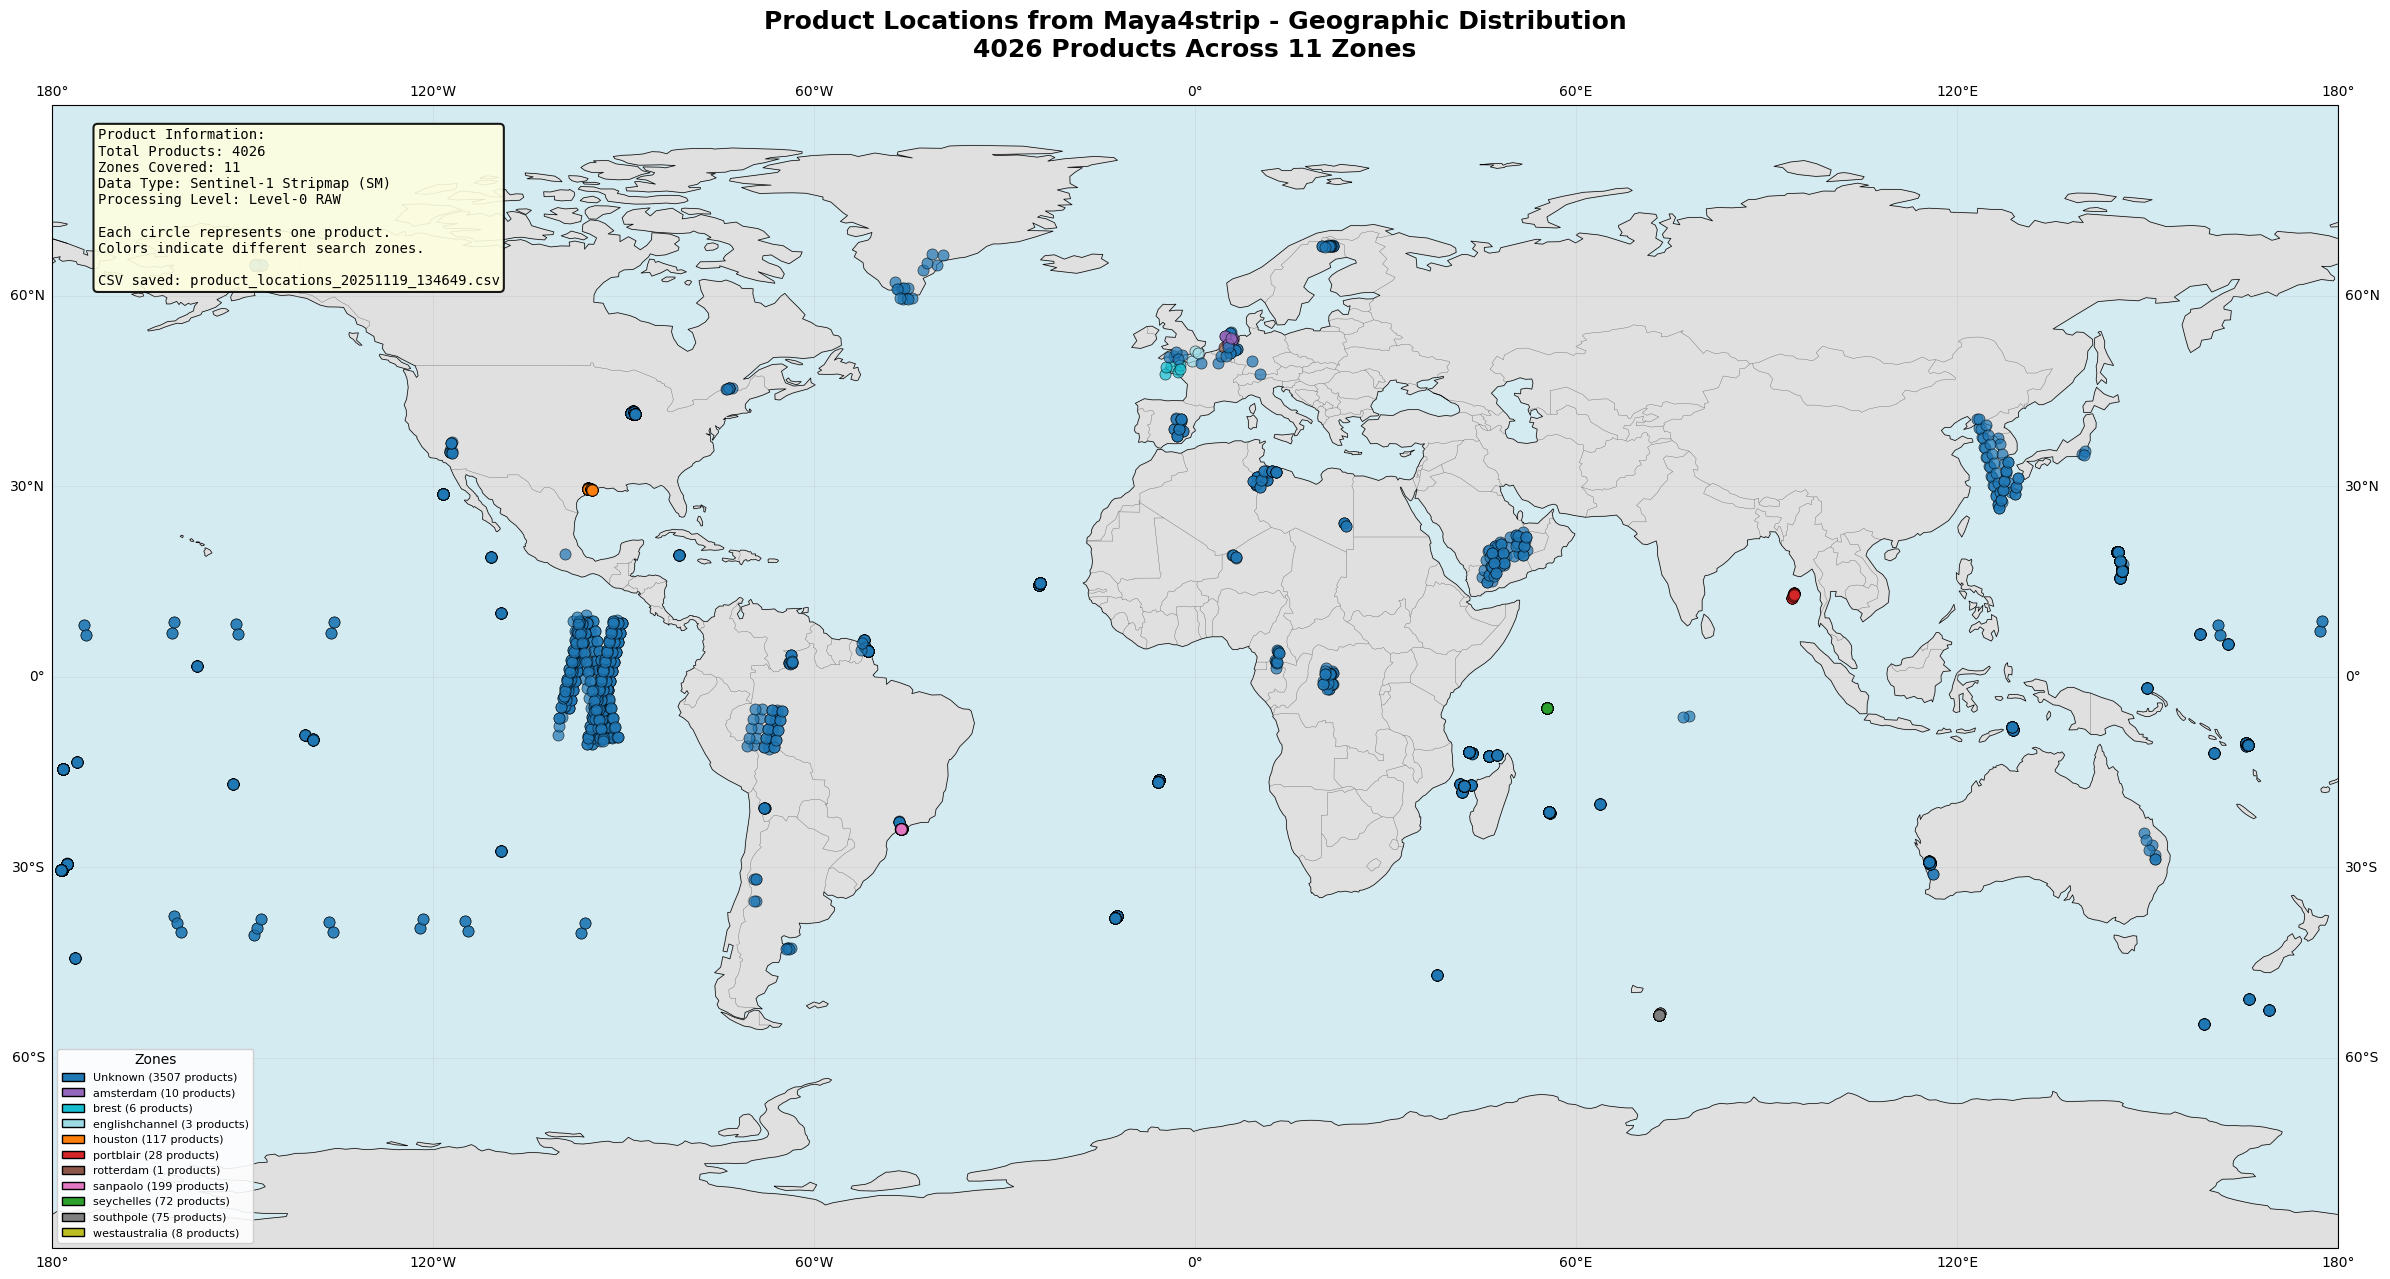


PRODUCT DISTRIBUTION SUMMARY

Unknown (3507 products):
  • Latitude range: -54.76° to 67.90°
  • Longitude range: -178.57° to 177.53°
  • Sample products:
    - S1A_S1_RAW__0SDH_20251117T121135_20251117T121206_061917_07BE34_9EE0.SAFE
    - S1C_S1_RAW__0SDH_20251116T213456_20251116T213516_005045_009FE4_E663.SAFE
    - S1C_S1_RAW__0SDH_20251116T213431_20251116T213504_005045_009FE4_02B9.SAFE

amsterdam (10 products):
  • Latitude range: 52.43° to 53.68°
  • Longitude range: 4.75° to 6.03°
  • Sample products:
    - S1C_S1_RAW__0SDH_20250506T170801_20250506T170834_002213_004B35_AB48.SAFE
    - S1C_S1_RAW__0SDV_20250424T170801_20250424T170839_002038_0042DF_F10E.SAFE
    - S1C_S2_RAW__0SDV_20250405T060506_20250405T060539_001754_00317B_2774.SAFE

brest (6 products):
  • Latitude range: 47.67° to 49.09°
  • Longitude range: -4.77° to -2.29°
  • Sample products:
    - S1C_S3_RAW__0SDV_20250327T063103_20250327T063138_001623_002929_3F53.SAFE
    - S1C_S6_RAW__0SDH_20250427T062323_20250427T062339

In [9]:
# Display product locations from Maya4strip dataframe on a world map
import matplotlib.pyplot as plt
from shapely.wkt import loads as load_wkt
from shapely.geometry import Polygon, Point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime

print("="*80)
print("PRODUCT LOCATION VERIFICATION")
print("="*80)

# Check if Maya4strip dataframe exists and has data
if 'Maya4strip' not in dir() or Maya4strip.empty:
    print("⚠️  Maya4strip dataframe is empty or not found. Please run the search cells first.")
else:
    print(f"✓ Found {len(Maya4strip)} products in Maya4strip dataframe")
    
    # Extract product locations from GeoFootprint
    product_records = []
    for idx, row in Maya4strip.iterrows():
        try:
            # GeoFootprint is already a dict, not a JSON string
            if pd.notna(row.get('GeoFootprint')):
                footprint = row['GeoFootprint']
                
                # Handle both dict and string formats
                if isinstance(footprint, str):
                    import json
                    footprint = json.loads(footprint)
                
                coordinates = footprint['coordinates'][0]
                
                # Calculate center of the footprint polygon
                lons = [coord[0] for coord in coordinates]
                lats = [coord[1] for coord in coordinates]
                center_lon = sum(lons) / len(lons)
                center_lat = sum(lats) / len(lats)
                
                # Find which zone this product belongs to
                product_zone = "Unknown"
                for zone_name in zones:
                    wkt_string = config['STRIPWKTS'][zone_name]
                    zone_polygon = load_wkt(wkt_string)
                    point = Point(center_lon, center_lat)
                    if zone_polygon.contains(point) or zone_polygon.intersects(point.buffer(0.1)):
                        product_zone = zone_name
                        break
                
                product_records.append({
                    'product_name': row.get('Name', 'Unknown'),
                    'zone_name': product_zone,
                    'latitude': center_lat,
                    'longitude': center_lon,
                    'publication_date': row.get('PublicationDate', 'Unknown'),
                    'swath': row.get('Attributes', {}).get('swathIdentifier', 'Unknown') if isinstance(row.get('Attributes'), dict) else 'Unknown'
                })
        except Exception as e:
            print(f"⚠️  Failed to parse product {idx}: {e}")
            continue
    
    print(f"✓ Successfully extracted {len(product_records)} product locations")
    
    # Save product information to CSV
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_filename = f'product_locations_{timestamp}.csv'
    
    products_df = pd.DataFrame(product_records)
    products_df.to_csv(csv_filename, index=False)
    print(f"\n💾 Saved product location information to: {csv_filename}")
    print(f"   Total products saved: {len(products_df)}")
    
    # Create world map visualization
    fig = plt.figure(figsize=(24, 14))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.5)
    ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5)
    ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.7)
    ax.gridlines(draw_labels=True, alpha=0.3, linewidth=0.5)
    
    print("\n📍 Plotting product locations on world map...")
    
    # Create color mapping for different zones
    import numpy as np
    unique_zones = products_df['zone_name'].unique()
    zone_colors = {}
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_zones)))
    for i, zone in enumerate(unique_zones):
        zone_colors[zone] = colors[i]
    
    # Plot each product as a circle
    for idx, product in products_df.iterrows():
        color = zone_colors.get(product['zone_name'], 'gray')
        ax.plot(product['longitude'], product['latitude'], 'o', 
               color=color, markersize=8, alpha=0.7,
               transform=ccrs.PlateCarree(), zorder=3,
               markeredgecolor='black', markeredgewidth=0.5)
    
    # Create legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=zone_colors[zone], edgecolor='black', 
                            label=f"{zone} ({len(products_df[products_df['zone_name']==zone])} products)")
                      for zone in sorted(unique_zones)]
    ax.legend(handles=legend_elements, loc='lower left', fontsize=8, 
             framealpha=0.9, title='Zones', title_fontsize=10)
    
    plt.title(f'Product Locations from Maya4strip - Geographic Distribution\n{len(products_df)} Products Across {len(unique_zones)} Zones',
              fontsize=18, fontweight='bold', pad=20)
    
    # Add info box
    info_text = f"""Product Information:
Total Products: {len(products_df)}
Zones Covered: {len(unique_zones)}
Data Type: Sentinel-1 Stripmap (SM)
Processing Level: Level-0 RAW

Each circle represents one product.
Colors indicate different search zones.

CSV saved: {csv_filename}"""
    
    props = dict(boxstyle='round', facecolor='lightyellow', alpha=0.9, edgecolor='black', linewidth=1.5)
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props, family='monospace')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n" + "="*80)
    print("PRODUCT DISTRIBUTION SUMMARY")
    print("="*80)
    
    # Group products by zone
    for zone in sorted(unique_zones):
        df_zone = products_df[products_df['zone_name'] == zone]
        print(f"\n{zone} ({len(df_zone)} products):")
        if len(df_zone) > 0:
            print(f"  • Latitude range: {df_zone['latitude'].min():.2f}° to {df_zone['latitude'].max():.2f}°")
            print(f"  • Longitude range: {df_zone['longitude'].min():.2f}° to {df_zone['longitude'].max():.2f}°")
            print(f"  • Sample products:")
            for i, (_, prod) in enumerate(df_zone.head(3).iterrows()):
                print(f"    - {prod['product_name']}")
    
    print(f"\n✅ Product location visualization complete!")
    print(f"\n📄 Product data saved to CSV file: {csv_filename}")
    print(f"   Columns: product_name, zone_name, latitude, longitude, publication_date, swath")


# Interactive Product Selection

Click on products in the map below to select/deselect them. Selected products will be highlighted. Click "SAVE SELECTION" to export the selected products to a CSV file.

In [10]:
# Interactive product selection using Plotly for fast rendering and smooth zooming
import plotly.graph_objects as go
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from datetime import datetime
import numpy as np

# Set wider display for the notebook output
display(HTML("<style>.jp-OutputArea-output {display: flex; flex-direction: column; width: 100%;}</style>"))

# Check if products_df exists from previous cell
if 'products_df' not in dir() or products_df.empty:
    print("⚠️  No product data available. Please run the previous cell first.")
else:
    print("="*80)
    print("INTERACTIVE PRODUCT SELECTION (Plotly)")
    print("="*80)
    print(f"📍 Total products available: {len(products_df)}")
    print("\nInstructions:")
    print("  1. Click on polygons to select/deselect products")
    print("  2. Selected products will turn RED")
    print("  3. Use mouse wheel or zoom controls to zoom in/out")
    print("  4. Click and drag to pan the map")
    print("  5. Click 'SAVE SELECTION' button to export to CSV")
    print("="*80)
    
    # Store selection state
    selected_indices = set()
    
    # Create output widget for messages
    output = widgets.Output()
    
    # Create color mapping for different zones
    unique_zones = products_df['zone_name'].unique()
    zone_colors_map = {}
    colors_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                      '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
                      '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
                      '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5']
    
    for i, zone in enumerate(unique_zones):
        zone_colors_map[zone] = colors_palette[i % len(colors_palette)]
    
    # Extract polygon coordinates from Maya4strip
    print("\n📐 Extracting product footprint polygons...")
    polygon_data = []
    
    for idx, row in products_df.iterrows():
        try:
            # Find corresponding product in Maya4strip
            product_name = row['product_name']
            maya_row = Maya4strip[Maya4strip['Name'] == product_name]
            
            if not maya_row.empty:
                footprint = maya_row.iloc[0]['GeoFootprint']
                
                # Handle both dict and string formats
                if isinstance(footprint, str):
                    import json
                    footprint = json.loads(footprint)
                
                # Extract coordinates (list of [lon, lat] pairs)
                coordinates = footprint['coordinates'][0]
                
                polygon_data.append({
                    'index': idx,
                    'product_name': row['product_name'],
                    'zone_name': row['zone_name'],
                    'coordinates': coordinates,
                    'color': zone_colors_map[row['zone_name']],
                    'center_lon': row['longitude'],
                    'center_lat': row['latitude'],
                    'publication_date': row['publication_date'],
                    'swath': row['swath']
                })
        except Exception as e:
            print(f"⚠️  Failed to extract polygon for product {idx}: {e}")
            continue
    
    print(f"✓ Successfully extracted {len(polygon_data)} product polygons")
    
    # Create initial figure
    fig = go.FigureWidget()
    
    # Prepare data for TWO separate traces - unselected (black) and selected (red)
    # This avoids rebuilding color arrays on every click
    
    # Helper function to build trace data from a list of polygon indices
    def build_trace_data(poly_indices):
        lons = []
        lats = []
        texts = []
        indices = []
        
        for i in poly_indices:
            poly = polygon_data[i]
            coords = poly['coordinates']
            poly_lons = [c[0] for c in coords] + [coords[0][0]]  # Close the polygon
            poly_lats = [c[1] for c in coords] + [coords[0][1]]
            
            lons.extend(poly_lons)
            lats.extend(poly_lats)
            
            # Repeat metadata for all points in this polygon
            for _ in poly_lons:
                texts.append(f"<b>{poly['product_name']}</b><br>Zone: {poly['zone_name']}<br>Date: {poly['publication_date']}<br>Swath: {poly['swath']}")
                indices.append(poly['index'])
            
            # Add None to separate polygons
            lons.append(None)
            lats.append(None)
            texts.append(None)
            indices.append(None)
        
        return lons, lats, texts, indices
    
    # Initially all products are unselected
    all_poly_indices = list(range(len(polygon_data)))
    unsel_lons, unsel_lats, unsel_texts, unsel_indices = build_trace_data(all_poly_indices)
    
    # Trace 0: Unselected products (black)
    scatter_unselected = go.Scattergeo(
        lon=unsel_lons,
        lat=unsel_lats,
        mode='lines',
        line=dict(width=1, color='black'),
        hovertemplate='%{text}<extra></extra>',
        text=unsel_texts,
        customdata=unsel_indices,
        showlegend=False,
        name='Unselected'
    )
    
    # Trace 1: Selected products (red) - initially empty
    scatter_selected = go.Scattergeo(
        lon=[],
        lat=[],
        mode='lines',
        line=dict(width=2, color='red'),
        hovertemplate='%{text}<extra></extra>',
        text=[],
        customdata=[],
        showlegend=False,
        name='Selected'
    )
    
    fig.add_trace(scatter_unselected)
    fig.add_trace(scatter_selected)
    
    # Update layout for better interactivity
    fig.update_geos(
        projection_type="natural earth",
        showcountries=True,
        showcoastlines=True,
        showland=True,
        landcolor="lightgray",
        coastlinecolor="darkgray",
        countrycolor="white",
        oceancolor="lightblue",
        showlakes=True,
        lakecolor="lightblue"
    )
    
    fig.update_layout(
        title={
            'text': f'Interactive Product Selection - Click polygons to select/deselect<br>Total: {len(polygon_data)} products | Selected: 0',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16}
        },
        height=900,
        width=1800,  # Set explicit width
        showlegend=False,
        margin=dict(l=0, r=0, t=80, b=0),
        autosize=False  # Disable autosize to respect width setting
    )
    
    def on_click(trace, points, selector):
        """Handle click events on products"""
        if len(points.point_inds) > 0:
            point_idx = points.point_inds[0]
            
            # Get customdata from the clicked trace
            customdata = trace.customdata
            
            # Get the product index from customdata
            if point_idx < len(customdata) and customdata[point_idx] is not None:
                idx = customdata[point_idx]
                
                with output:
                    if idx in selected_indices:
                        selected_indices.remove(idx)
                        print(f"⊟ Deselected: {products_df.iloc[idx]['product_name']}")
                    else:
                        selected_indices.add(idx)
                        print(f"⊞ Selected: {products_df.iloc[idx]['product_name']}")
                
                update_display()
    
    def update_display():
        """Update visual display by rebuilding the two traces"""
        # Get indices for unselected and selected products
        unselected_poly_indices = [i for i in range(len(polygon_data)) 
                                   if polygon_data[i]['index'] not in selected_indices]
        selected_poly_indices = [i for i in range(len(polygon_data)) 
                                if polygon_data[i]['index'] in selected_indices]
        
        # Rebuild unselected trace (trace 0)
        unsel_lons, unsel_lats, unsel_texts, unsel_indices = build_trace_data(unselected_poly_indices)
        fig.data[0].lon = unsel_lons
        fig.data[0].lat = unsel_lats
        fig.data[0].text = unsel_texts
        fig.data[0].customdata = unsel_indices
        
        # Rebuild selected trace (trace 1)
        sel_lons, sel_lats, sel_texts, sel_indices = build_trace_data(selected_poly_indices)
        fig.data[1].lon = sel_lons
        fig.data[1].lat = sel_lats
        fig.data[1].text = sel_texts
        fig.data[1].customdata = sel_indices
        
        # Update title
        fig.layout.title.text = f'Interactive Product Selection - Click polygons to select/deselect<br>Total: {len(polygon_data)} products | Selected: {len(selected_indices)}'
    
    def save_selection(b):
        """Save selected products to CSV"""
        with output:
            if len(selected_indices) == 0:
                print("\n⚠️  No products selected! Please select at least one product.")
                return
            
            # Create dataframe of selected products
            selected_products = products_df.iloc[list(selected_indices)]
            
            # Generate filename with timestamp
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f'selected_products_{timestamp}.csv'
            
            # Save to CSV
            selected_products.to_csv(filename, index=False)
            
            print("\n" + "="*80)
            print("✅ SELECTION SAVED!")
            print("="*80)
            print(f"📄 File: {filename}")
            print(f"📊 Products saved: {len(selected_products)}")
            print(f"\nBreakdown by zone:")
            for zone in sorted(selected_products['zone_name'].unique()):
                count = len(selected_products[selected_products['zone_name'] == zone])
                print(f"  • {zone}: {count} products")
            print("="*80)
    
    def select_all(b):
        """Select all products"""
        with output:
            selected_indices.clear()
            selected_indices.update(range(len(products_df)))
            print(f"\n✅ Selected all {len(products_df)} products")
        update_display()
    
    def clear_all(b):
        """Clear all selections"""
        with output:
            count = len(selected_indices)
            selected_indices.clear()
            print(f"\n🗑️  Cleared {count} selected products")
        update_display()
    
    def clear_output_log(b):
        """Clear the output log"""
        with output:
            clear_output()
    
    # Connect click events to BOTH traces
    fig.data[0].on_click(on_click)
    fig.data[1].on_click(on_click)
    
    # Create buttons
    btn_save = widgets.Button(
        description='SAVE SELECTION',
        button_style='success',
        tooltip='Save selected products to CSV',
        icon='save'
    )
    btn_select_all = widgets.Button(
        description='SELECT ALL',
        button_style='info',
        tooltip='Select all products',
        icon='check-square'
    )
    btn_clear_all = widgets.Button(
        description='CLEAR ALL',
        button_style='warning',
        tooltip='Clear all selections',
        icon='eraser'
    )
    btn_clear_log = widgets.Button(
        description='CLEAR LOG',
        button_style='',
        tooltip='Clear output messages',
        icon='trash'
    )
    
    # Connect button callbacks
    btn_save.on_click(save_selection)
    btn_select_all.on_click(select_all)
    btn_clear_all.on_click(clear_all)
    btn_clear_log.on_click(clear_output_log)
    
    # Create button layout
    button_box = widgets.HBox([btn_save, btn_select_all, btn_clear_all, btn_clear_log])
    
    # Display widgets
    display(button_box)
    display(fig)
    display(output)
    
    print("\n💡 Tip: Use scroll wheel to zoom, click and drag to pan. Click polygons to select!")


INTERACTIVE PRODUCT SELECTION (Plotly)
📍 Total products available: 4026

Instructions:
  1. Click on polygons to select/deselect products
  2. Selected products will turn RED
  3. Use mouse wheel or zoom controls to zoom in/out
  4. Click and drag to pan the map
  5. Click 'SAVE SELECTION' button to export to CSV

📐 Extracting product footprint polygons...
✓ Successfully extracted 4026 product polygons
✓ Successfully extracted 4026 product polygons


FigureWidget({
    'data': [{'customdata': [0, 0, 0, ..., 4025, 4025, None],
              'hovertemplate': '%{text}<extra></extra>',
              'lat': [40.607, 42.4449, 42.5556, ..., 14.1234, 14.1234, None],
              'line': {'color': 'black', 'width': 1},
              'lon': [-88.2859, -87.7645, -88.7127, ..., -24.5538, -24.5538, None],
              'mode': 'lines',
              'name': 'Unselected',
              'showlegend': False,
              'text': [<b>S1A_S1_RAW__0SDH_20251117T121135_20251117T121206_061917_
                       07BE34_9EE0.SAFE</b><br>Zone: Unknown<br>Date:
                       2025-11-17T12:33:01.294201Z<br>Swath: Unknown, <b>S1A_S1_RAW
                       __0SDH_20251117T121135_20251117T121206_061917_07BE34_9EE0.SA
                       FE</b><br>Zone: Unknown<br>Date:
                       2025-11-17T12:33:01.294201Z<br>Swath: Unknown, <b>S1A_S1_RAW
                       __0SDH_20251117T121135_20251117T121206_061917_07BE34_9EE0.SA
   

Output()


💡 Tip: Use scroll wheel to zoom, click and drag to pan. Click polygons to select!
